In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 561ms/step - loss: 0.0164
Average validation loss: 0.6541879177093506
4/4 [==============================] - 5s 574ms/step - loss: 0.0164 - val_loss: 0.6542
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 554ms/step - loss: 0.0101 - val_loss: 0.6542
Average validation loss: 0.6433229446411133
4/4 [==============================] - 7s 567ms/step - loss: 0.0101 - val_loss: 0.6488
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 9s 563ms/step - loss: 0.0074 - val_loss: 0.6488
Average validation loss: 0.641191840171814
4/4 [==============================] - 9s 574ms/step - loss: 0.0074 - val_loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 510ms/step - loss: 6.9864e-07
Average validation loss: 0.0050102719105780125
8/8 [==============================] - 4s 519ms/step - loss: 6.9864e-07 - val_loss: 0.0050
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 8s 507ms/step - loss: 6.8575e-07 - val_loss: 0.0050
Average validation loss: 0.005374429747462273
8/8 [==============================] - 8s 516ms/step - loss: 6.8575e-07 - val_loss: 0.0052
Epoch 3/10
8/8 [==============================] - 12s 505ms/step - loss: 6.5898e-07 - val_loss: 0.0052
Average validation loss: 0.004087469773367047
8/8 [==============================] - 12s 514ms/step - loss: 6.5898e-07 - val_loss: 0.0048
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segfo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 6s 508ms/step - loss: 2.1148e-06
Average validation loss: 0.08346837964685012
12/12 [==============================] - 6s 515ms/step - loss: 2.1148e-06 - val_loss: 0.0835
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 12s 505ms/step - loss: 2.0664e-06 - val_loss: 0.0835
Average validation loss: 0.09438151121139526
12/12 [==============================] - 12s 513ms/step - loss: 2.0664e-06 - val_loss: 0.0889
Epoch 3/10
12/12 [==============================] - 18s 506ms/step - loss: 2.1928e-06 - val_loss: 0.0889
Average validation loss: 0.10792440336914903
12/12 [==============================] - 19s 515ms/step - loss: 2.1928e-06 - val_loss: 0.0953
Epoch 4/10
12/12 [==============================] - 25s 506ms/step - loss: 2.1492e-06 - val_loss: 0.0953
Average validation 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 8s 510ms/step - loss: 1.7372e-06
Average validation loss: 0.07953741843812168
16/16 [==============================] - 8s 519ms/step - loss: 1.7372e-06 - val_loss: 0.0795
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 16s 508ms/step - loss: 1.7499e-06 - val_loss: 0.0795
Average validation loss: 0.0586390953976661
16/16 [==============================] - 17s 515ms/step - loss: 1.7499e-06 - val_loss: 0.0691
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 25s 507ms/step - loss: 1.6894e-06 - val_loss: 0.0691
Average validation loss: 0.04200995585415512
16/16 [==============================] - 25

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 10s 511ms/step - loss: 6.4836e-07
Average validation loss: 0.06330935284495354
20/20 [==============================] - 10s 518ms/step - loss: 6.4836e-07 - val_loss: 0.0633
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 21s 508ms/step - loss: 6.1842e-07 - val_loss: 0.0633
Average validation loss: 0.05984818637371063
20/20 [==============================] - 21s 516ms/step - loss: 6.1842e-07 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 31s 509ms/step - loss: 6.0216e-07 - val_loss: 0.0616
Average validation loss: 0.068628990650177
20/20 [==============================] - 3

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 12s 512ms/step - loss: 6.6650e-07
Average validation loss: 0.1162865584095319
24/24 [==============================] - 12s 520ms/step - loss: 6.6650e-07 - val_loss: 0.1163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 25s 509ms/step - loss: 7.4353e-07 - val_loss: 0.1163
Average validation loss: 0.07757375265161197
24/24 [==============================] - 25s 517ms/step - loss: 7.4353e-07 - val_loss: 0.0969
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 37s 509ms/step - loss: 7.2536e-07 - val_loss: 0.0969
Average validation loss: 0.09048988297581673
24/24 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 21s 513ms/step - loss: 1.3798e-06
Average validation loss: 0.215618859231472
40/40 [==============================] - 21s 522ms/step - loss: 1.3798e-06 - val_loss: 0.2156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 42s 516ms/step - loss: 1.4535e-06 - val_loss: 0.2156
Average validation loss: 0.08377187252044678
40/40 [==============================] - 42s 524ms/step - loss: 1.4535e-06 - val_loss: 0.1497
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 62s 514ms/step - loss: 1.4233e-06 - val_loss: 0.1497
Average validation loss: 0.0659813079982996
40/40 [==============================] - 63

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 25s 518ms/step - loss: 9.2555e-07
Average validation loss: 0.09871805366128683
48/48 [==============================] - 25s 526ms/step - loss: 9.2555e-07 - val_loss: 0.0987
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 50s 514ms/step - loss: 7.2551e-07 - val_loss: 0.0987
Average validation loss: 0.04636714735534042
48/48 [==============================] - 50s 522ms/step - loss: 7.2551e-07 - val_loss: 0.0725
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 75s 516ms/step - loss: 6.2414e-07 - val_loss: 0.0725
Average validation loss: 0.051555437850765884
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 29s 516ms/step - loss: 1.3916e-06
Average validation loss: 0.05853045124760164
56/56 [==============================] - 29s 524ms/step - loss: 1.3916e-06 - val_loss: 0.0585
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 58s 518ms/step - loss: 1.1644e-06 - val_loss: 0.0585
Average validation loss: 0.0572043868846127
56/56 [==============================] - 59s 526ms/step - loss: 1.1644e-06 - val_loss: 0.0579
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 88s 518ms/step - loss: 9.4628e-07 - val_loss: 0.0579
Average validation loss: 0.05645414095904146
56/56 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 33s 520ms/step - loss: 4.0525e-07
Average validation loss: 0.04095523551222868
64/64 [==============================] - 34s 528ms/step - loss: 4.0525e-07 - val_loss: 0.0410
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 67s 518ms/step - loss: 3.4865e-07 - val_loss: 0.0410
Average validation loss: 0.05090568347077351
64/64 [==============================] - 67s 526ms/step - loss: 3.4865e-07 - val_loss: 0.0459
Epoch 3/10
64/64 [==============================] - 101s 517ms/step - loss: 2.9483e-07 - val_loss: 0.0459
Average validation loss: 0.05157990730367601
64/64 [==============================] - 101s 525ms/step - loss: 2.9483e-07 - val_loss: 0.0478
Epoch 4/10
64/64 [==============================] - 134s 518ms/step - loss: 2.5733e-07 - val_loss: 0.0478
Average valida

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 38s 528ms/step - loss: 4.2527e-07
Average validation loss: 0.050526373295320406
72/72 [==============================] - 39s 536ms/step - loss: 4.2527e-07 - val_loss: 0.0505
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 76s 524ms/step - loss: 2.9433e-07 - val_loss: 0.0505
Average validation loss: 0.04466845498730739
72/72 [==============================] - 77s 532ms/step - loss: 2.9433e-07 - val_loss: 0.0476
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 115s 527ms/step - loss: 2.3667e-07 - val_loss: 0.0476
Average validation loss: 0.04532065149396658
72/72 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 42s 527ms/step - loss: 4.6405e-07
Average validation loss: 0.0381913710385561
80/80 [==============================] - 43s 535ms/step - loss: 4.6405e-07 - val_loss: 0.0382
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 85s 525ms/step - loss: 3.3180e-07 - val_loss: 0.0382
Average validation loss: 0.05381173510104418
80/80 [==============================] - 85s 533ms/step - loss: 3.3180e-07 - val_loss: 0.0460
Epoch 3/10
80/80 [==============================] - 128s 527ms/step - loss: 2.7254e-07 - val_loss: 0.0460
Average validation loss: 0.04258146490901708
80/80 [==============================] - 128s 535ms/step - loss: 2.7254e-07 - val_loss: 0.0449
Epoch 4/10
80/80 [==============================] - 170s 526ms/step - loss: 2.3236e-07 - val_loss: 0.0449
Average valida

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 51s 528ms/step - loss: 1.9716e-06
Average validation loss: 0.10056989906782594
96/96 [==============================] - 51s 536ms/step - loss: 1.9716e-06 - val_loss: 0.1006
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 102s 526ms/step - loss: 1.3230e-06 - val_loss: 0.1006
Average validation loss: 0.053502786167276405
96/96 [==============================] - 103s 534ms/step - loss: 1.3230e-06 - val_loss: 0.0770
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 153s 525ms/step - loss: 9.7964e-07 - val_loss: 0.0770
Average validation loss: 0.07009372309160729
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 65s 540ms/step - loss: 7.1437e-07
Average validation loss: 0.04083673999023934
120/120 [==============================] - 66s 548ms/step - loss: 7.1437e-07 - val_loss: 0.0408
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 131s 543ms/step - loss: 4.8067e-07 - val_loss: 0.0408
Average validation loss: 0.03751565696826826
120/120 [==============================] - 132s 551ms/step - loss: 4.8067e-07 - val_loss: 0.0392
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 197s 543ms/step - loss: 3.6949e-07 - val_loss: 0.0392
Average validation loss: 0.04144556812049511
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 78s 541ms/step - loss: 4.6107e-07
Average validation loss: 0.044339455431327224
144/144 [==============================] - 79s 550ms/step - loss: 4.6107e-07 - val_loss: 0.0443
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 157s 541ms/step - loss: 3.0481e-07 - val_loss: 0.0443
Average validation loss: 0.03873015226822139
144/144 [==============================] - 158s 550ms/step - loss: 3.0481e-07 - val_loss: 0.0415
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 236s 541ms/step - loss: 2.4053e-07 - val_loss: 0.0415
Average validation loss: 0.028208513032748468
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 87s 542ms/step - loss: 2.9035e-07
Average validation loss: 0.04585119637195021
160/160 [==============================] - 88s 550ms/step - loss: 2.9035e-07 - val_loss: 0.0459
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 175s 541ms/step - loss: 2.1098e-07 - val_loss: 0.0459
Average validation loss: 0.05398503385076765
160/160 [==============================] - 176s 549ms/step - loss: 2.1098e-07 - val_loss: 0.0499
Epoch 3/10
160/160 [==============================] - 262s 539ms/step - loss: 1.7454e-07 - val_loss: 0.0499
Average validation loss: 0.0531985113339033
160/160 [==============================] - 263s 547ms/step - loss: 1.7454e-07 - val_loss: 0.0510
Epoch 4/10
160/160 [==============================] - 350s 539ms/step - loss: 1.4908e-07 - val_loss: 0.051

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 108s 541ms/step - loss: 1.0863e-06
Average validation loss: 0.04554399140179157
200/200 [==============================] - 110s 549ms/step - loss: 1.0863e-06 - val_loss: 0.0455
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 218s 540ms/step - loss: 8.4060e-07 - val_loss: 0.0455
Average validation loss: 0.05327627697959542
200/200 [==============================] - 219s 548ms/step - loss: 8.4060e-07 - val_loss: 0.0494
Epoch 3/10
200/200 [==============================] - 327s 540ms/step - loss: 6.4493e-07 - val_loss: 0.0494
Average validation loss: 0.05772612037137151
200/200 [==============================] - 329s 548ms/step - loss: 6.4493e-07 - val_loss: 0.0522
Epoch 4/10
200/200 [==============================] - 437s 540ms/step - loss: 5.2380e-07 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:03 - loss: 2.0725e-08

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 125s 521ms/step - loss: 3.5401e-07
Average validation loss: 0.060765365758076464
240/240 [==============================] - 127s 529ms/step - loss: 3.5401e-07 - val_loss: 0.0608
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 252s 520ms/step - loss: 2.3136e-07 - val_loss: 0.0608
Average validation loss: 0.04734885747360143
240/240 [==============================] - 254s 528ms/step - loss: 2.3136e-07 - val_loss: 0.0541
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_50\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 379s 521ms/step - loss: 1.8332e-07 - val_loss: 0.0541
Average validation loss: 0.05577003986157555
240/240 [=============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12293803993961774, 0.04422880248188449, 0.08131383683068936, 0.10913815474021249, 0.08145529653830455, 0.07716213094691435, 0.09825795207172633, 0.055527300438067556, 0.04899979518393853, 0.04338602064861334, 0.040226297031703225, 0.04031647805884132, 0.054325742842535565, 0.04005884873622563, 0.04368260200455551, 0.042221615733240465, 0.049816948362346736, 0.046706366851586315]
std_val_losses =  [0.20556202777187682, 0.03205277230546313, 0.03866557105226493, 0.060558717419988285, 0.02547595067696179, 0.022269779118739317, 0.05314353907505062, 0.018590782042209333, 0.012608112829752728, 0.009884300857744959, 0.005889313698301699, 0.009344725015321647, 0.030204931693788198, 0.00911935501630798, 0.007061604204301666, 0.009658958025267611, 0.009700128088699791, 0.011163572187350404]


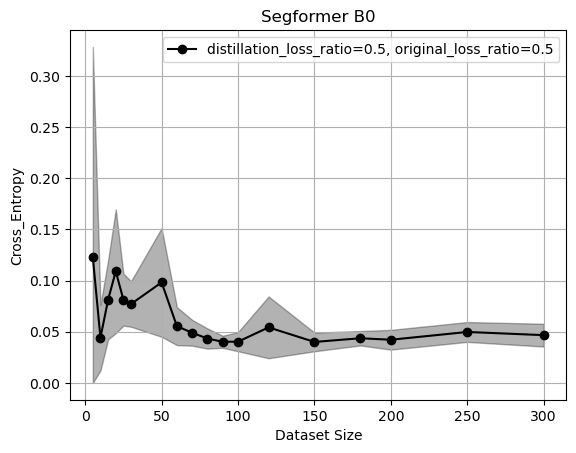

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()